# MATEMATYKA FINANSOWA - Laboratorium 5
Stanisław Pawlak

In [153]:
import scipy.stats
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import  e, sqrt, factorial, floor, log

## Zadanie 1

$ c(S_{0},T,K,\sigma,r) :=S_{0}\Phi(d_{+}(S_{0},T,K,\sigma,r))− Ke^{−rT}\Phi(d_{−}(S_{0},T,K,\sigma,r)),$

gdzie $\Phi$ jest dystrybuantą rozkładu $N(0,1)$ oraz 

$ d_{±}(S_{0},T,K,\sigma,r) :=\frac{log \frac{S_{0}}{K} + (r± \frac{\sigma^{2}}{2})T}{\sigma \sqrt{T}}.$

Zauważmy też, że $d_{+}() = d_{-}() - \sigma \sqrt{T}$

In [157]:
def d1(S0, T, K, sigma, r):
    return (log(S0/K) + (r + sigma**2 /2)*T)/(sigma*sqrt(T))

def d2(S0, T, K, sigma, r):
    return d1(S0, T, K, sigma, r) -  sigma*sqrt(T)

def BS_price(S0, T, K, sigma, r):
    return S0* norm.cdf(d1(S0, T, K, sigma, r)) - K*e**(-r*T)*norm.cdf(d2(S0, T, K, sigma, r))

BS_price(100, 1, 100, 0.1, 0.1)

10.308150925634422

Implementacja Modelu CRR:

In [159]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()


In [160]:
class BankAccount:
    def __init__(self, r):
        self.r = r

    def get_bank_account_value(self, t):
        return (1 + self.r) ** t


class MarketInstrument:
    def __init__(self, S_0):
        self.S_0 = S_0

    def calculate_call_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_call_option_value, market, T, K)
        
    def calculate_put_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_put_option_value, market, T, K)

    def _calculate_option_value(self, option_func_type, market, t, K):
        prices = [option_func_type(t, t-j, market.d, market.u, K) for j in range(0, t+1)]
        return self._get_value(t, prices, market.d, market.u, market.r, market.p)
    
    def _get_value(self, t, prices, d, u,r, p):
        if t == 0:
            return prices[0]
        else:
            for i in range(0, t):
                prices[i] =1/(1+r)*(p*prices[i] + (1-p)*prices[i+1])
            #print(prices[:t])
            return self._get_value(t-1, prices, d, u,r,  p)

    
    def get_call_option_value(self, t, j, d, u, K):
        return max(self.S_0 * u ** j * d ** (t - j) - K, 0)
    
    def get_put_option_value(self, t, j, d, u, K):
        return max(K - self.S_0 * u ** j * d ** (t - j), 0)

hide_toggle()

In [161]:
class CRRMarket:
    def __init__(self, S_0_values, d, u, r, T):
        self.B = BankAccount(r)
        self.p = (1 + r - d) / (u - d)
        self.S = [MarketInstrument(S_0_values[i]) for i in range(0, len(S_0_values))]
        self.d = d
        self.u = u
        self.r = r
        self.T = T
    
    def calculate_call_options_values(self, T, K):
        return [s.calculate_call_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
    def calculate_put_options_values(self, T, K):
        return [s.calculate_put_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
hide_toggle()

In [162]:
import scipy.special
def calculate_option_value_theory(option_func_type, market, t, K):
        scaling_value = 1 / market.B.get_bank_account_value(t)
        sum = 0
        for j in range(0, t+1):
            sum += scipy.special.comb(t, j, exact=True) * market.p ** j * (1 - market.p) ** (t - j) * option_func_type(t, j, market.d, market.u, K)
        return sum * scaling_value
hide_toggle()

In [171]:
def CRR_prep(T, n, sigma, r):
    r_n = r * T/n
    a_n = sigma * sqrt(T/n)
    u_n = e** (a_n) * (1+r_n)
    d_n = e** (-a_n) * (1+r_n)
    return d_n, u_n, r_n, n

prices = []
step=1
left, right = 600, 1000 #2000
for n in tqdm(range(left, right, step)):
    example_market = CRRMarket([100], *CRR_prep(T=1, n=n, sigma=0.1, r=0.1))
    prices.append(example_market.S[0].calculate_call_option_value(example_market,example_market.T, 100))

100%|██████████| 400/400 [00:22<00:00, 18.01it/s]


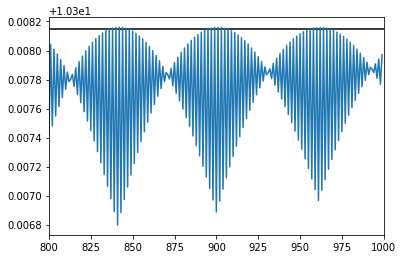

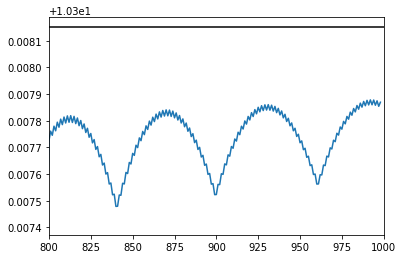

In [170]:
plt.xlim(left, right)
plt.plot([prices[0]]*left +prices)
plt.hlines(c(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

plt.xlim(left, right)
plt.plot([prices[0]]*left + [(prices[i-1] +prices[i])/2 for i in range(1, len(prices))])
plt.hlines(c(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

## Zadanie 2

In [214]:
args={
    'n':1000, 
    'S_0':100, 
    'T':1, 
    'sigma':0.1, 
    'r':0.1, 
    'K':100
}

In [257]:
def update_mean(means, i, update_value):
    if not means:
        means.append(update_value)
    else:
        means.append(np.average([means[i-1], update_value], weights = [i, 1]))
    return means

def approximation(value_function, St_function, generated_normal_variables,  n, **kwargs):
    means = []
    for i in tqdm(range(0, n)):
        value = value_function(St_function, generated_normal_variables[i], **kwargs)
        means = update_mean(means, i, value)
    return means

def MC_approximation(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    return e ** (-r*T) * max(St - K, 0)

def generate_single_S_T(Z, S_0, T, sigma, r):
    return S_0*e**(sigma*sqrt(T)*Z + (r - sigma**2/2)*T)

In [258]:
mc= approximation(MC_approximation,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(mc)

100%|██████████| 1000/1000 [00:00<00:00, 37985.00it/s]


DescribeResult(nobs=1000, minmax=(0.0, 10.438608111609556), mean=9.333138292585007, variance=0.7030677953183073, skewness=-5.688921167209525, kurtosis=51.300499474428634)

(a) metoda zmiennych kontrolnych

In [267]:
def control_variables(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    k = e ** (-r*T) * St
    value = e ** (-r*T) * max(St-K, 0) - k + S_0
    return value

In [259]:
cw = approximation(control_variables,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(cw)

100%|██████████| 1000/1000 [00:00<00:00, 34300.54it/s]


DescribeResult(nobs=1000, minmax=(9.516258196404038, 14.38982845649793), mean=10.405782791235607, variance=0.0403553551890729, skewness=10.361486470669242, kurtosis=176.90146088607423)

(b) metoda zmiennych kontrolnych w wersji turbo

In [13]:
def control_variables_turbo(n, S_T, S_0, T, sigma, r, K):
    means = []
    values= []
    X_mean = []
    Y_mean = []
    sum_covariances = 0
    sum_variances= 0
    b= 0
    for i in tqdm(range(0, n)):
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        if not means:
            values.append(value)
            means.append(value)
            X_mean.append(value)
            Y_mean.append(S_T[i])
        else:
            values.append(value)
            X_mean.append(np.average([X_mean[i-1], value], weights = [i, 1]))
            Y_mean.append(np.average([Y_mean[i-1], S_T[i]], weights = [i, 1]))
            sum_covariances += (value - X_mean[i])*(S_T[i]- Y_mean[i]) 
            sum_variances += (S_T[i]- Y_mean[i]) **2
            b_hat = sum_covariances/sum_variances
            means.append(np.average([means[i-1], value-b_hat*S_T[i]], weights = [i, 1]))
            b=b_hat
    return [x + b*Y_mean[-1] for x in means]

(c) metoda zmiennych antytetycznych

In [242]:
def antitetic_variables(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    St_prim = St_function(-Z, S_0, T, sigma, r)
    
    value = e ** (-r*T) * max(St-K, 0)
    value_prim = e ** (-r*T) * max(St_prim-K, 0)
    
    return (value + value_prim)/2

In [260]:
av = approximation(antitetic_variables,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(av)

100%|██████████| 1000/1000 [00:00<00:00, 33450.33it/s]


DescribeResult(nobs=1000, minmax=(9.125266255144187, 10.963529232136064), mean=10.362799129401518, variance=0.017162718678272116, skewness=-4.823053611267922, kurtosis=50.416448867625355)

(d) metoda warstwowania

In [261]:
def generate_wiener_for_layer(n, T, i, k):
    return [sqrt(T)* scipy.stats.norm.ppf(((i-1)+ np.random.uniform())/k) for j in range(0, n)]

def generate_wiener_layers(N_vector, T):
    layers = []
    for i, n in enumerate(N_vector):
        layers.append(generate_wiener_for_layer(n, T, i+1, len(N_vector)))
    return layers

def calculate_S_T(wiener_values, S_0, T, sigma, r):
    return [S_0*e**(sigma*wiener_values[i] + (r - sigma**2/2)*T) for i in range(0, len(wiener_values))]

In [262]:
def stratified_sampling(layers,n, S_0, T, sigma, r, K):
    means = []
    for wiener_values in tqdm(generate_wiener_layers(layers, T)):
        layer_means = []
        S_T = calculate_S_T(wiener_values, S_0, T, sigma, r)
        for i in range(0, len(wiener_values)):
            value = e ** (-r*T) * max(S_T[i]-K, 0)
            if not layer_means:
                layer_means.append(value)
            else:
                layer_means.append(np.average([layer_means[i-1],value], weights = [i, 1]))
        means.append(layer_means)
    return np.average(means, axis=0, weights=[x/len(layers) for x in layers])

In [250]:
scipy.stats.describe(stratified_sampling([100]*100 , **args))

100%|██████████| 100/100 [00:00<00:00, 485.07it/s]


DescribeResult(nobs=100, minmax=(10.253182600076377, 10.319014571243905), mean=10.310415262356459, variance=9.522586171604898e-05, skewness=-3.173467637441665, kurtosis=12.895731583785688)

(e) metoda importance sampling

In [268]:
def f_Wiener(Y, T):
    return scipy.stats.norm.pdf(Y, scale=T)

def f_Y(Y, mu, T):
    return scipy.stats.norm.pdf(Y, loc=mu, scale=T)

def importance_sampling(St_function, Z, S_0, T, sigma, r, K, mu):
    Y = Z * T + mu
    St = St_function(Y,S_0, T, sigma, r)
    value =  e ** (-r*T) * max(St-K, 0) * (f_Wiener(Y,T)/f_Y(Y, mu, T))
    return value

In [266]:
import_sampl = approximation(importance_sampling, generate_single_S_T, np.random.normal(size=args['n']), **args, mu=0.5)
scipy.stats.describe(import_sampl)

100%|██████████| 1000/1000 [00:00<00:00, 4623.85it/s]


DescribeResult(nobs=1000, minmax=(9.787330329879572, 12.107539584363558), mean=10.14362959051914, variance=0.11380428161255624, skewness=2.83260267051583, kurtosis=9.314766509656096)

100%|██████████| 100000/100000 [00:22<00:00, 4500.24it/s]


[0.07520924377336209,
 0.0374034874193673,
 0.012792421518168203,
 0.007917101769589234,
 0.010620884453251739,
 0.013109311777784162,
 0.006548824501422702,
 0.0028599794201027945,
 0.003803054586925443,
 0.002023744365376127,
 0.0018502261482834224,
 0.002113430718512918,
 0.0024469545706534666,
 0.005201339872968517,
 0.002010197143618485,
 0.005080690646068504,
 0.0017815335900798527,
 0.007101019162600878,
 0.005344177994217243,
 0.017523930721300644]

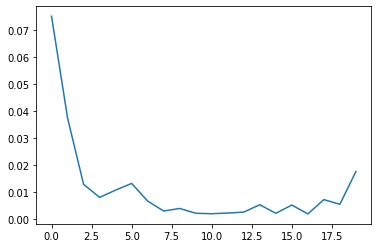

In [148]:
w = [scipy.stats.describe(importance_sampling(mu=i, n=100000 , S_0=100, T=1, sigma=0.1, r = 0.1, K=100)).variance for i in np.linspace(-0.5, 1.5, 20)]
plt.plot(w)
w

Na podstawie symulacji wybrano $\mu = 0.5$ jako wartość najbardziej minimalizującą wariancję.

In [14]:
scipy.stats.describe(control_variables_turbo(n=100000, S_T=S_T[0], S_0=100, T=1, sigma=0.1, r = 0.1, K=100))

100%|██████████| 100000/100000 [00:06<00:00, 14947.44it/s]


DescribeResult(nobs=100000, minmax=(6.8982358659506815, 93.28314752716159), mean=10.190279909368948, variance=0.12160503243561717, skewness=145.43521315300907, kurtosis=33270.13790122944)

In [10]:
# def control_variables(n, S_T, S_0, T, sigma, r, K):
#     means = []
#     for i in tqdm(range(0, n)):
#         k = e ** (-r*T) * S_T[i]
#         value = e ** (-r*T) * max(S_T[i]-K, 0)
#         if not means:
#             means.append(value-k)
#         else:
#             means.append(np.average([means[i-1], value-k], weights = [i, 1]))
#     return [x + S_0 for x in means]

In [6]:
# n = 100000
# number_of_vectors = 1
# vectors = [generate_S_T_vectors(n=n, S_0=100, T=1, sigma=0.1, r = 0.1) for i in range(0, number_of_vectors)]
# S_T = np.array([vectors[x][y][0] for x in range(0, number_of_vectors) for y in range(0,n)]).reshape(number_of_vectors, n)
# S_T_prim = np.array([vectors[x][y][1] for x in range(0, number_of_vectors) for y in range(0,n)]).reshape(number_of_vectors, n)

100%|██████████| 100000/100000 [00:02<00:00, 49443.85it/s]


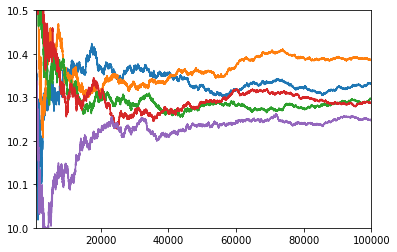

In [333]:
# plt.xlim(10**3, 10**5)
# plt.ylim(10, 10.5)
# for i in range(0, 5):
#     plt.plot(MC_approximation(n=100000, S_0=100, T=1, sigma=0.1, r = 0.1, K=100))
# plt.show()

In [131]:
w = scipy.stats.describe(importance_sampling(mu=0, n=100 , S_0=100, T=1, sigma=0.1, r = 0.1, K=100))

100%|██████████| 100/100 [00:00<00:00, 2995.70it/s]


## Zadanie 3

Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Stanisław Pawlak